# Fraud visualisation in banking transactions using t-SNE

Использована обучающая выборка с разметкой (фрод/не фрод) с соревнования kaggle: https://www.kaggle.com/kartik2112/fraud-detection.

В обучающей выборке 1296675 наблюдений, из них отмечено как "фрод" - 7506 наблюдений (или 0.58%).
Всего в обучающей выборке 23 аттрибута.

Аттрибуты в обучающей выборке можно разделить на 3 ключевые категории: 
- person (информация о плательщике:  first, last, cc_num, dob, zip, gender, street, city, state, zip, lat, long, city_pop, job), 
- merchant (организация-получатель платежа:  merchant, category)
- transaction (информация о транзации: trans_num, unix_time, trans_date_trans_time, merch_lat, merch_long)

In [ ]:
#tsne
#https://www.youtube.com/watch?v=pFFHvgAti7I

In [1]:
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians, log, log1p
import random
from time import gmtime, strftime
import copy
from sklearn.manifold import TSNE
import seaborn as sns
import requests

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set(rc={'figure.figsize':(14,14)})
sns.set_style("whitegrid")

In [2]:
def read_csv_from_url(url, file_name):
    """Обучающая и тестовая выборки предварительно загружены на яндекс-диск
    Функция выполняет скачивание и загрузку в датафрейм csv-файла по заданной ссылке"""
    r = requests.get(url, allow_redirects=True)
    open(file_name, 'wb').write(r.content)
    return pd.read_csv(file_name)

In [4]:
def calc_distance(lat1, long1, lat2, long2):
    """Определение дистанции между точками"""
    R = 6373.0 # примерный радиус Земли в км
    lat1 = radians(lat1)
    lon1 = radians(long1)
    lat2 = radians(lat2)
    lon2 = radians(long2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [5]:
def preprocess_features_basic(df):
    """Функция добавляет к датафрейму аттрибуты:
    - trans_hour     - час транзакции;
    - trans_week_day - день недели транзакции;
    - birth_year     - год рождения плательщика;
    - trans_distance - дистанция между местом жительства плательщика и местом транзакции;
    - trans_hex_id   - пространственный индекс места совершения операции (см. https://eng.uber.com/h3/)
    """
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Preprocess features: trans_hour, trans_dttm, dob, trans_week_day, trans_hex_id')
    df['trans_hour'] = df.loc[:,'trans_date_trans_time'].str[11:13]
    df['trans_dttm'] = pd.to_datetime(df.loc[:,'trans_date_trans_time'])
    df['birth_year'] = df.loc[:,'dob'].str[0:4].astype('int')
    df['trans_week_day'] = df.loc[:,'trans_dttm'].apply(lambda x: x.strftime('%A'))
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Preprocess features: trans_distance')
    df['trans_distance'] = df.apply(lambda row: calc_distance(row["lat"], row["long"], row["merch_lat"], row["merch_long"]), axis = 1)
    #df['trans_hex_id'] = df.apply(lambda row: h3.geo_to_h3(row["merch_lat"], row["merch_long"], resolution = 3), axis = 1)
    return df

In [6]:
def target_share_by_feature(feature_name, target_name, df):
    """Функция рассчитывает характеристику встречаемости фрода для каждого значения
    категориального аттрибута.
    Возвращает датафрейм из 3х колонок: наименование аттрибута, количество единичек, долю единичек.
    """
    agg_df = df.groupby([feature_name,target_name], as_index=False)\
            .aggregate({'unix_time' : 'count'})\
            .rename(columns = {'unix_time': 'cnt'})
    pivot_df = agg_df.pivot(index=feature_name, columns=target_name).fillna(0)
    flat_df = pd.DataFrame(pivot_df.to_records())
    flat_df.columns = [feature_name, 'target_0', 'target_1']
    flat_df['target_share'] = flat_df['target_1'] / (flat_df['target_0'] + flat_df['target_1'])
    flat_df.sort_values(by='target_share', ascending=False, inplace = True)
    flat_df.columns = [feature_name, feature_name + '_target_0_cnt', feature_name + '_target_1_cnt', feature_name + '_target_share']
    flat_df = flat_df.drop(feature_name + '_target_0_cnt', axis = 1)
    return flat_df

In [7]:
def get_typical_zip_ref(train, min_typical_trans_cnt = 400):
    """Создадим справочник типовых локаций"""
    zip_df = train.loc[train['is_fraud']==0,:].groupby(['zip','is_fraud'], as_index=False)\
            .aggregate({'unix_time' : 'count'})\
            .rename(columns = {'unix_time': 'cnt'})
    typical_zip = list(zip_df.loc[zip_df['cnt']>min_typical_trans_cnt,:]['zip'])
    return typical_zip

In [8]:
def get_typical_job_ref(train, min_typical_trans_cnt = 400):
    """Создадим справочник типовых должностей"""
    job_df = train.loc[train['is_fraud']==0,:].groupby(['job','is_fraud'], as_index=False)\
            .aggregate({'unix_time' : 'count'})\
            .rename(columns = {'unix_time': 'cnt'})
    typical_job = list(job_df.loc[job_df['cnt']>min_typical_trans_cnt,:]['job'])
    return typical_job

In [9]:
def mark_typical_features(train, test = None, type_cd = 'train'):
    """Добавим фичи:
    - typical_zip - признак типовой локации
    - typical_job - признак типовой должности
    """
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Preprocess features: mark typical_zip, typical_job')
    typical_zip_ref = get_typical_zip_ref(train)
    typical_job_ref = get_typical_job_ref(train)
    if type_cd == 'train':
        df = train
    if type_cd == 'test':
        df = test
    df['typical_zip'] = df['zip'].isin(typical_zip_ref).astype(int)
    df['typical_job'] = df['job'].isin(typical_job_ref).astype(int)
    return df

In [10]:
def mark_earlier_fraudsters(train, test = None, type_cd = 'train'):
    """Разметим карточки, которые ранее были уличены во фроде
    Функция добавляет к датафрейму колонку earlier_fraudster со значениями 1 или 0
    В train обязательно устраняем лик, когда разметка берется из будущего"""
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Preprocess features: mark earlier fraudsters')
    fraudster_list = list(set(train.loc[train['is_fraud']==1,'cc_num']))
    if type_cd == 'train':
        first_fraud_dttm = train.loc[train['is_fraud']==1,:]\
        .groupby(['cc_num','is_fraud'], as_index=False)\
        .aggregate({'unix_time' : 'min'})
        first_fraud_dttm['first_fraud_flag']=1
        train = train.merge(first_fraud_dttm, on=['cc_num','unix_time'], how='left')\
                     .rename(columns = {'is_fraud_x':'is_fraud'})
        train['earlier_fraudster'] = train['cc_num'].isin(fraudster_list).astype(int)
        train.loc[train['first_fraud_flag']==1,'earlier_fraudster'] = 0
        train.drop(['is_fraud_y','first_fraud_flag'], axis = 1, inplace = True)
        return train
    if type_cd == 'test':
        test['earlier_fraudster'] = test['cc_num'].isin(fraudster_list).astype(int)
        return test

In [11]:
def get_first_transaction_time(train, test = None, type_cd = 'train'):
    """Определим время первой транзакции для каждой карточки"""
    if type_cd == 'train':
        cc_num_min_time = train.groupby(['cc_num'], as_index=False)\
                .aggregate({'unix_time' : 'min'})\
                .rename(columns = {'unix_time': 'first_trans_time'})
        return cc_num_min_time
    if type_cd == 'test':
        frames = [train, test]
        train_test_concat = pd.concat(frames)
        cc_num_min_time = train_test_concat.groupby(['cc_num'], as_index=False)\
                .aggregate({'unix_time' : 'min'})\
                .rename(columns = {'unix_time': 'first_trans_time'})
        return cc_num_min_time

In [12]:
def mark_life_time_days(train, test = None, type_cd = 'train'):
    """Посчитаем время жизни карточки с момента первой транзакции"""
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Preprocess features: calc life time days')
    cc_num_min_time = get_first_transaction_time(train, test, type_cd)
    if type_cd == 'train':
        df = train
    if type_cd == 'test':
        df = test
    df = df.merge(cc_num_min_time, on='cc_num', how='left')
    df['life_time_days'] = df['unix_time'] - df['first_trans_time']
    df['life_time_days'].fillna(0, inplace = True)
    df['life_time_days'] = df['life_time_days'] / (60*60*24)
    df['life_time_days'] = df['life_time_days'].apply(lambda x: x + random.uniform(0.05,0.5))
    df['life_time_days'] = df['life_time_days'].round(3)
    return df

In [13]:
def mark_merchant_fraud_share(train, test = None, type_cd = 'train'):
    """Определим долю фрода по каждому продавцу"""
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Preprocess features: mark merchant fraud share')
    merchant_fraud_share = target_share_by_feature('merchant', 'is_fraud', train)
    merchant_fraud_share.drop('merchant_target_1_cnt', axis = 1, inplace = True)
    if type_cd == 'train':
        df = train
    if type_cd == 'test':
        df = test
    df = df.merge(merchant_fraud_share, on='merchant', how='left')
    df['merchant_target_share'].fillna(0, inplace = True)
    return df

In [14]:
def delete_unwanted_features(df):
    """ Удалим лишние аттрибуты """
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Deleting unwanted features')
    features_to_delete = ['Unnamed: 0','trans_date_trans_time','cc_num','merchant',
                          'first','last','street','city','state','zip','lat','long',
                          'job','dob','trans_num','unix_time','merch_lat','merch_long',
                          'trans_dttm','first_trans_time']
    df.drop(features_to_delete, axis = 1, inplace = True)
    return df

In [15]:
def z_scale(feature_name_list, train, test = None, type_cd = 'train'):
    """Функция выполняет Z-масштабирование аттрибутов: (x - mean) / standard_deviation
    """
    # Standardscaler - есть стандатная функция.
    for feature_name in list(feature_name_list):
        print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Z scale: ' + feature_name)
        mean_x = train[feature_name].mean()
        std_x = train[feature_name].std()
        if type_cd == 'train':
            df = train
        if type_cd == 'test':
            df = test
        df[feature_name+'_stdnorm'] = df[feature_name].apply(lambda x: (x - mean_x) / (std_x))
        df = df.drop(feature_name, axis = 1)
    return df

In [16]:
def min_max_scale(df, feature_name_list):
    """ Функция выполняет min-max нормализацию аттрибутов: (x - min_x) / (max_x-min_x)
    """
    # MinMaxScaler (стандартная функция sklearn)
    for feature_name in list(feature_name_list):
        print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Min_max_scale: ' + feature_name)
        min_x = df[feature_name].min()
        max_x = df[feature_name].max()
        df[feature_name+'_norm'] = df[feature_name].apply(lambda x: (x - min_x) / (max_x-min_x))
        df = df.drop(feature_name, axis = 1)
    return df

In [17]:
def one_hot_encode(df, col_name):
    """ Функция выполняет one hot encoding по списку аттрибутов
    """
    #pd.get_dummies(df[colnames_list])
    # лишний цикл. заменить на pd.get_dummies(test[['category','gender']])
    #заменить col_name
    for i in list(col_name):
        print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' One hot encoding: ' + i)
        one_hot = pd.get_dummies(df[i])
        one_hot.columns = i + '_' + one_hot.columns
        df = df.drop(i, axis = 1)
        df = df.join(one_hot)
    return df

In [21]:
train = read_csv_from_url('https://getfile.dokpub.com/yandex/get/https://yadi.sk/d/BXKOOeLfLQvfqw', 'fraudTrain.csv')

In [22]:
train = preprocess_features_basic(train)
train = mark_life_time_days(train)

2021-09-07 17:15:48 Preprocess features: trans_hour, trans_dttm, dob, trans_week_day, trans_hex_id
2021-09-07 17:16:02 Preprocess features: trans_distance
2021-09-07 17:17:25 Preprocess features: calc life time days


In [23]:
train = mark_typical_features(train)
train = mark_earlier_fraudsters(train)
train = mark_merchant_fraud_share(train)
train = delete_unwanted_features(train)

2021-09-07 17:17:29 Preprocess features: mark typical_zip, typical_job
2021-09-07 17:17:31 Preprocess features: mark earlier fraudsters
2021-09-07 17:17:37 Preprocess features: mark merchant fraud share
2021-09-07 17:17:41 Deleting unwanted features


In [24]:
features_to_scale = ['amt','city_pop', 'trans_distance', 'life_time_days', 'birth_year']
train = z_scale(features_to_scale, train)

2021-09-07 17:17:41 Z scale: amt
2021-09-07 17:17:42 Z scale: city_pop
2021-09-07 17:17:43 Z scale: trans_distance
2021-09-07 17:17:43 Z scale: life_time_days
2021-09-07 17:17:44 Z scale: birth_year


In [25]:
train = one_hot_encode(train, ['category','gender','trans_hour', 'trans_week_day'])

2021-09-07 17:17:45 One hot encoding: category
2021-09-07 17:17:45 One hot encoding: gender
2021-09-07 17:17:46 One hot encoding: trans_hour
2021-09-07 17:17:46 One hot encoding: trans_week_day


In [26]:
# В обучающей выборке сильный дисбаланс классов.
# Выполним сэмплирование так, чтобы примерно уравновесить баланс
X = pd.concat([train[train.is_fraud==0].sample(frac=0.02, replace=False, random_state=1),
               train[train.is_fraud==1].sample(frac=0.99, replace=False, random_state=1)
              ])
y = X.loc[:,'is_fraud']
X = X.drop('is_fraud', axis = 1)

In [27]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 46106 samples in 1.070s...
[t-SNE] Computed neighbors for 46106 samples in 6.780s...
[t-SNE] Computed conditional probabilities for sample 1000 / 46106
[t-SNE] Computed conditional probabilities for sample 2000 / 46106
[t-SNE] Computed conditional probabilities for sample 3000 / 46106
[t-SNE] Computed conditional probabilities for sample 4000 / 46106
[t-SNE] Computed conditional probabilities for sample 5000 / 46106
[t-SNE] Computed conditional probabilities for sample 6000 / 46106
[t-SNE] Computed conditional probabilities for sample 7000 / 46106
[t-SNE] Computed conditional probabilities for sample 8000 / 46106
[t-SNE] Computed conditional probabilities for sample 9000 / 46106
[t-SNE] Computed conditional probabilities for sample 10000 / 46106
[t-SNE] Computed conditional probabilities for sample 11000 / 46106
[t-SNE] Computed conditional probabilities for sample 12000 / 46106
[t-SNE] Computed conditional probabilities for sam

[Text(0.5, 1.0, 'Credit card fraud detection')]

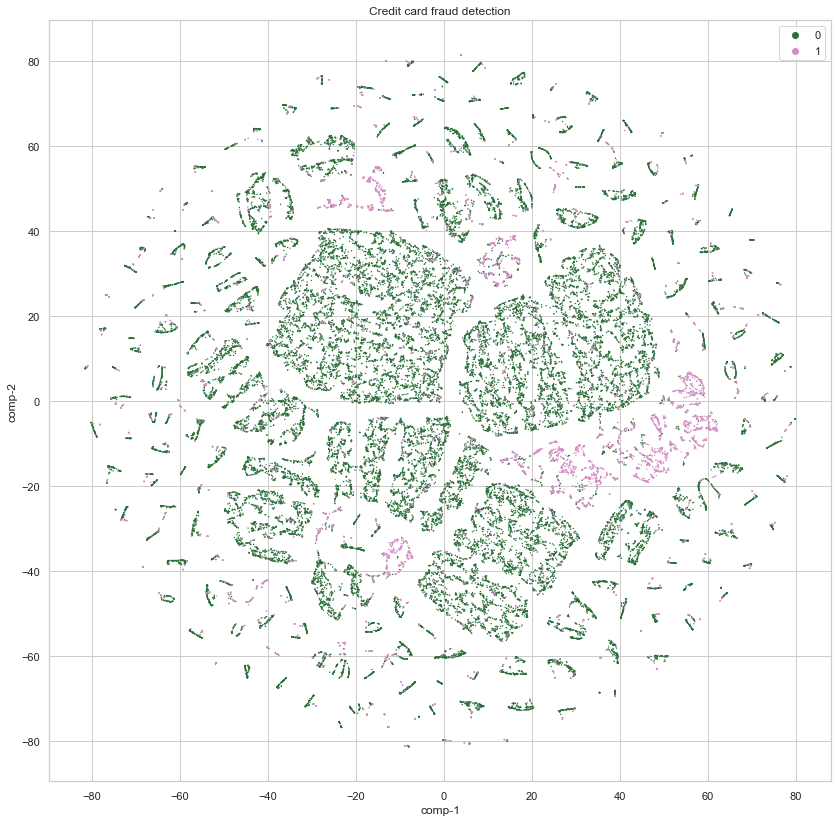

In [28]:
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("cubehelix", 2),
                s=2,
                linewidth=0,
                data=df).set(title="Credit card fraud detection")

Вывод: *t-SNE визуализация дает понять, что в ряде случаев фродовые транзакции маскируются под нефродовые (сливаются с ними в одни группы), однако есть группы, которые практически целиком относятся к фродовым*

Такие группы легко детектировать методами кластеризации, например, k-means